# 1. Setting Up


Banks are always concerned with fraud to prevent from those intending to misuse the system to take advantage of it. In this section, we will build a classification model to predict whether or not an applicant is committing bank fraud. We will practice to use Decision Trees for the purpose.Along with that, we will also develop our own custom classifier class, a majority class classifier.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

np.random.seed(416)

Let's create a helper function to create confusion matrices

In [2]:
from sklearn.metrics import confusion_matrix

def visualize_confusion_matrix(test, pred, score):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15)

# 2. Inspecting Data

In [3]:
bank_fraud = pd.read_csv('bank_fraud.csv')
bank_fraud = bank_fraud.drop(columns = ['Unnamed: 0'])
print(len(bank_fraud))
bank_fraud.head()

20000


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


# 3. Pre-processing

## Data revamp 
The target column (label column) of the dataset that we are interested in is called `fraud_bool`. In this column 1 means fraudulent and 0 means  legitimate application.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:

* +1 as legitimate,
* -1 as fraud.

We put this in a new column called `not_fraud`. This column will be the target values you will use while training.

In [4]:
bank_fraud['not_fraud'] = bank_fraud['fraud_bool'].apply(lambda x : +1 if x==0 else -1)

# Drop the old fraud_bool column
bank_fraud = bank_fraud.drop(columns='fraud_bool')

Now, let's see the proportion of fraudulent and not fraudulent applications in our data

In [5]:
only_legit = bank_fraud[bank_fraud['not_fraud'] == 1]
only_fraud = bank_fraud[bank_fraud['not_fraud'] == -1]

print(f'Number of legit applications: {len(only_legit)} ({len(only_legit) * 100.0 / len(bank_fraud):.2f}%)')
print(f'Number of fraud applications: {len(only_fraud)} ({len(only_fraud) * 100.0 / len(bank_fraud):.2f}%)')

Number of legit applications: 18572 (92.86%)
Number of fraud applications: 1428 (7.14%)


## Feature Selection
We will be using the following features in the fraud dataset. These values are both numeric and categorical

In [6]:
features = [
    'income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month' 
]

target = 'not_fraud'   

# Extract the feature columns and target column
bank_fraud = bank_fraud[features + [target]]
bank_fraud.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,not_fraud
0,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,10650.765523,...,500.0,0,INTERNET,3.888115,windows,0,1,0,7,-1
1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,534.047319,...,1500.0,0,INTERNET,31.798819,windows,0,1,0,7,-1
2,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,4048.534263,...,200.0,0,INTERNET,4.728705,other,0,1,0,7,-1
3,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,3457.064063,...,200.0,0,INTERNET,2.047904,linux,0,1,0,7,-1
4,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,5020.341679,...,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7,-1


Let's take a look at all the features we have in colums again

In [7]:
print("features: ", bank_fraud.columns)

features:  Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'not_fraud'],
      dtype='object')


With how `sklearn` implemented its `DecisionTreeClassifier`, it is only able to handle numerical features; the technical reason being it only allows binary splits and assumes (like other `sklearn` models), that the data is only numerical. This means we need to translate the categorical features into numeric ones. 

The easiest way to do this is a **one-hot encoding** of each categorical feature. We used this method in Section 2 for the same reasons. A one hot encoding of a feature creates new, derived, features that take on the value 0 or 1 (one new feature for each possible value of the original). This allows us to turn a categorical feature into a series of binary (0 or 1) numerical features.

For example, if we had the dataset shown below where 'Gender' takes on values 'M' (Male), 'F' (Female), 'O' (Other) and 'HasHouse' takes on values 'Y' (Yes), and 'N' (No). This dataset would not work by default in scikit-learn since it has features with categorical values.

| Gender | HasHouse | Age |
|--------|----------|-----|
| M      | N        | 19  |
| F      | Y        | 23  |
| O      | Y        | 24  |
| F      | N        | 21  |

To fix this, we could use a one-hot encoding to transform the categorical features into numeric ones. A one-hot encoding of the categorical features would be 

| Gender_M | Gender_F | Gender_O | HasHouse_N | HasHouse_Y | Age |
|----------|----------|----------|------------|------------|-----|
| 1        | 0        | 0        | 1          | 0          | 19  |
| 0        | 1        | 0        | 0          | 1          | 23  |
| 0        | 0        | 1        | 0          | 1          | 24  |
| 0        | 1        | 0        | 1          | 0          | 21  |

Note that the original 'Gender' column has been transformed into three related columns 'Gender_M', 'Gender_F', and 'Gender_O' which contains zeros or ones depending on the rows' original value. For each row, only one of these derived columns will contain a one (hence the name one-hot encoding).

To do this in `pandas`, we use the `get_dummies()` method (another name for one-hot encoding, is dummy variable). We show the new features of the data after running the function in the next cell.

In [8]:
bank_fraud = pd.get_dummies(bank_fraud)
features = list(bank_fraud.columns)
features.remove('not_fraud')
features

['income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'bank_months_count',
 'has_other_cards',
 'proposed_credit_limit',
 'foreign_request',
 'session_length_in_minutes',
 'keep_alive_session',
 'device_distinct_emails_8w',
 'device_fraud_count',
 'month',
 'payment_type_AA',
 'payment_type_AB',
 'payment_type_AC',
 'payment_type_AD',
 'payment_type_AE',
 'employment_status_CA',
 'employment_status_CB',
 'employment_status_CC',
 'employment_status_CD',
 'employment_status_CE',
 'employment_status_CF',
 'employment_status_CG',
 'housing_status_BA',
 'housing_status_BB',
 'housing_status_BC',
 'housing_status_BD',
 'housing_status_BE',
 'housing_status_BF',
 'source_I

## Train Test Split

Let's split our data in standard train-test split manner

In [9]:
train_val, test_data = train_test_split(bank_fraud, test_size = 0.1)
train_data, validation_data = train_test_split(train_val, test_size=0.2)

# 5. Decision Tree Classifiers

Next, we will code a decision tree classifier for the same data. See the documentation for [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

**Conceptual Question**: Is "fraudulent bank applications" the type of classification problem that decision trees are well-suited for? Why or why not?

**Answer:** 


Complete the code block below

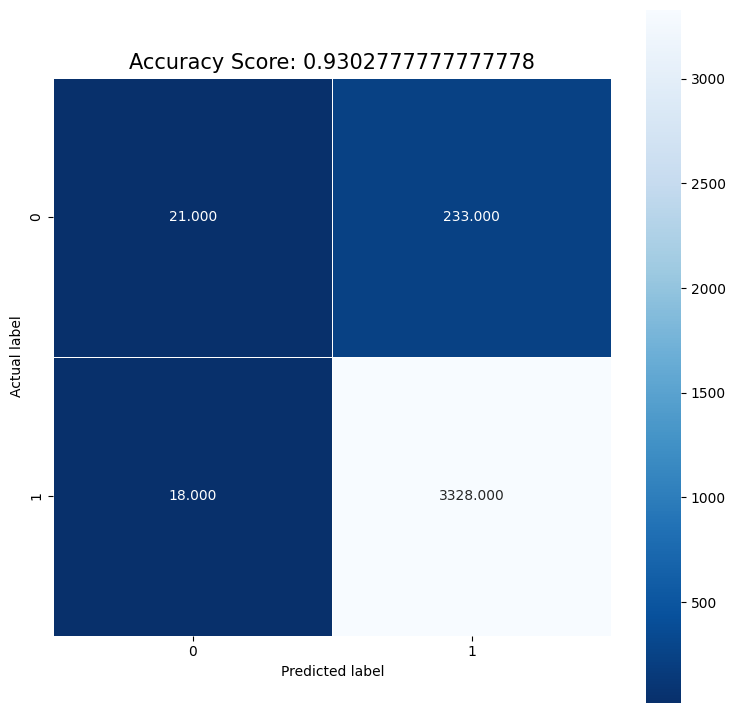

In [10]:
import sklearn

# Create the decision tree with max_depth = 4 and random_state = 7
# TODO Task 1
dt = DecisionTreeClassifier(max_depth=4, random_state=7)

#Fit the training data to decision tree
# TODO Task 2
dt.fit(train_data[features], train_data[target])

# Let's see and visualize how our predictions look
dt_y_pred = dt.predict(validation_data[features])
dt_score = dt.score(validation_data[features], validation_data[target])
visualize_confusion_matrix(validation_data[target], dt_y_pred, dt_score)

**Discussion:** Now, try to alter the max depth of the tree. What do you see?

**Answer:**

Now, let's visualize the tree we are making. Note that if you alter the `max_depth` in code below, you will need to save the image to view it in full.

In [11]:
import graphviz
from sklearn import tree


def draw_tree(tree_model, features):
    """
    visualizes a Decision Tree
    """
    tree_data = tree.export_graphviz(tree_model, 
                                    impurity=False, 
                                    feature_names=features,
                                    class_names=tree_model.classes_.astype(str),
                                    filled=True,
                                    out_file=None)
    graph = graphviz.Source(tree_data) 
    display(graph)
    
small_tree_model = DecisionTreeClassifier(max_depth=2, random_state=0)
small_tree_model.fit(train_data[features], train_data[target])
draw_tree(small_tree_model, features)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

# 6. Implementing a Majority Class Classifier

Now, we will have you create your own classifier. You will fill in the code below for a Majority Class Classifier. Remember a majority class classifier is simply where every point in the class is assigned to the majority of the training set.

In [12]:
# implement a class
class MajorityClassClassifier:
    # *NOTE: we can assume we are recieving numpy arrays
    #        for our x and y parameters*

    def __init__(self):
        # input: none
        # output: none

        # task 3: create a private variable to keep track of
        #         the majority label
        self._majority_label = None 

    def fit(self, x, y):
        # input: target and label data
        # output: none
        # Hint: see optional parameters for https://numpy.org/doc/stable/reference/generated/numpy.unique.html
        # task 4: find the majority label
        vals, counts = np.unique(x, return_counts=True)
        index = np.argmax(counts)
        self._majority_label = vals[index]
        

    def predict(self, x):
        # input: target data
        # output: predicted results

        # task 5: predict using the majority label
        if self._majority_label is None:
            return None
        else:
            return np.array([self._majority_label for i in x])

    def score(self, x, y):
        # input: target and label data
        # output: accuracy score of our classifier

        # task 6: give the accuracy score on the data
        majority = y[y == self._majority_label]
        return len(majority) / len(y)
        
        

# 6. Using our implemented class

0.0


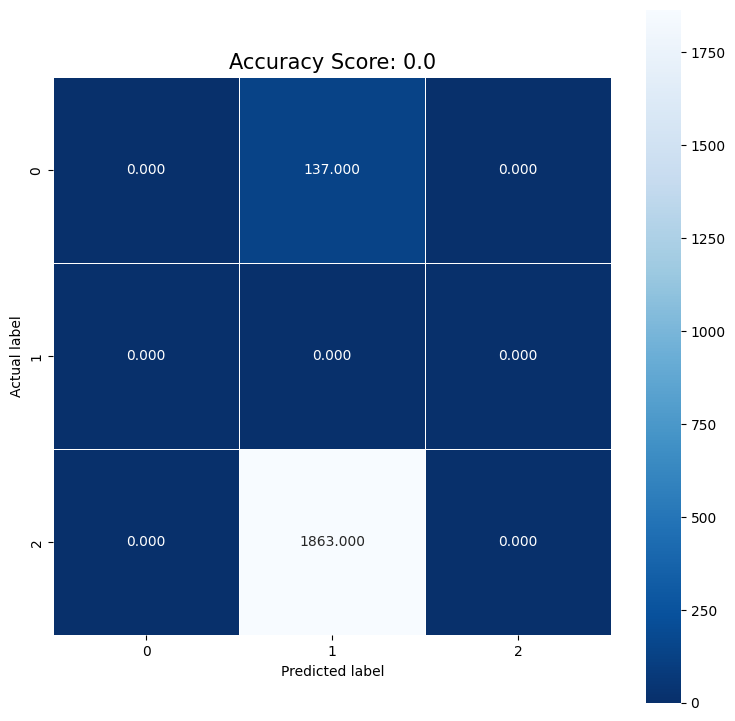

In [13]:
# task 7: create your majority class classifier model
mcc = MajorityClassClassifier()

# task 8: fit the data to the model
mcc.fit(train_data[features], train_data[target])
# task 9: print the testing score from using our implemented class
mcc_score = mcc.score(test_data[features], test_data[target])
print(mcc_score)
# task 10: predict on x_test and save it to mc_y_pred
mc_y_pred = mcc.predict(test_data[target])
# task 11: visualize the confusion matrix
visualize_confusion_matrix(test_data[target], mc_y_pred, mcc_score)

**Conceptual Question**: Why is the Majority Class Classifier accuracy so high? 

**Answer:**


Below are additional resources for the content covered in this section.

* [Dummy Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)

Further is more Documentation for GridSearch
* [What is Grid Search?](https://medium.com/fintechexplained/what-is-grid-search-c01fe886ef0a#:~:text=Grid%20search%20is%20a%20tuning,us%20time%2C%20effort%20and%20resources.)
* [Grid Search for model tuning](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)
